Download the data

In [1]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  3071k      0  0:04:11  0:04:11 --:--:-- 3061k0:02:28 3041k  3036k      0  0:04:14  0:01:57  0:02:17 3038k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  2473k      0  0:00:07  0:00:07 --:--:-- 2813k


Prepare paths of input images and target segmentation masks

In [2]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32
epochs = 15

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


What does one input image and corresponding segmentation mask look like?

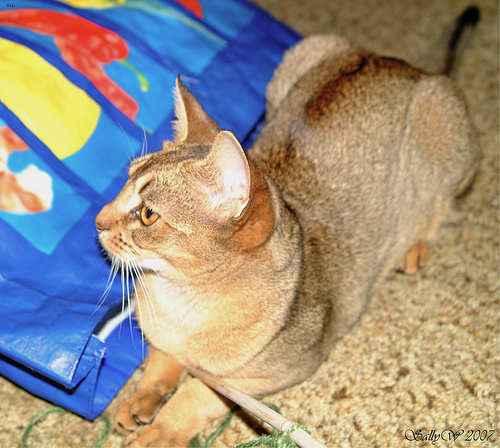

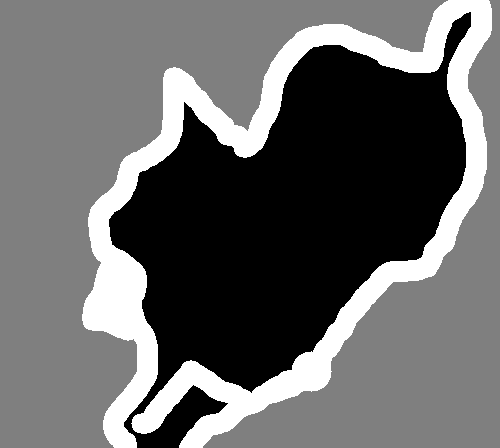

In [3]:
from IPython.display import display
from PIL import Image, ImageOps

# Display input image #7
display(Image.open(input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(Image.open(target_img_paths[9]))
display(img)

Prepare Sequence class to load & vectorize batches of data

In [4]:
import jax
import jax.numpy as jnp

class OxfordPets():
  """Helper to iterate over the data (as Numpy arrays)."""
  def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.input_img_paths = input_img_paths
    self.target_img_paths = target_img_paths
  
  @staticmethod
  def standardize(img_input):
    num_pixels = jnp.prod(jnp.asarray(img_input.shape[-3:]))
    img_mean = jnp.mean(img_input, axis=[-1, -2, -3], keepdims=True)
    
    stddev = jnp.std(img_input, axis=[-1, -2, -3], keepdims=True)
    min_stddev = jnp.divide(1., jnp.sqrt(num_pixels))
    adjusted_stddev = jnp.maximum(stddev, min_stddev)
    
    img_input = jnp.subtract(img_input, img_mean)
    img_input = jnp.divide(img_input, adjusted_stddev)
    
    return img_input
  
  def load(self, path_input, path_target):
    img_input = jnp.asarray(Image.open(path_input))
    if len(img_input.shape) != 3:
      img_input = jnp.expand_dims(img_input, 2)
      img_input = jnp.tile(img_input, 3)
    img_input = jax.image.resize(img_input,
                                 shape=(self.img_size[0], self.img_size[1], 3),
                                 method="nearest")
    
    img_input = self.standardize(img_input)
      
    img_target = jnp.asarray(Image.open(path_target))
    # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
    img_target = img_target - 1
    img_target = jax.image.resize(img_target,
                                  shape=(self.img_size[0], self.img_size[1]),
                                  method="nearest")
    
    return img_input.astype("float32"), img_target.astype("uint8")

  def __len__(self):
    return len(self.target_img_paths) // self.batch_size

  def __getitem__(self, idx):
    """Returns tuple (input, target) correspond to batch #idx."""
    i = idx * self.batch_size
    batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
    batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
    x = jnp.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
    y = jnp.zeros((self.batch_size,) + self.img_size, dtype="uint8")
    for j, (path_input, path_target) in enumerate(zip(batch_input_img_paths, batch_target_img_paths)):
      img_input, img_target = self.load(path_input, path_target)
      x = x.at[j].set(img_input)
      y = y.at[j].set(img_target)
  
    return x, y

Create SeperableConv2D and UpSampling2D as in the same way defined in Keras

In [5]:
from typing import Mapping, NamedTuple, Optional, Union

import haiku as hk
import optax

class SeparableConv2D(hk.Module):
  def __init__(self,
               output_channels: int,
               with_bias: bool,
               name: Optional[str] = None):

    super().__init__(name=name)

    self.depthwise = hk.DepthwiseConv2D(
      channel_multiplier=1,
      kernel_shape=3,
      stride=1,
      padding="SAME",
      with_bias=with_bias,
      data_format="NHWC",
      name="depthwise_kernel")

    self.pointwise = hk.Conv2D(
      output_channels=output_channels,
      kernel_shape=1,
      stride=1,
      padding="VALID",
      with_bias=with_bias,
      data_format="NHWC",
      name="pointwise_kernel")


  def __call__(self, inputs: jnp.ndarray):
    out = inputs
    out = self.depthwise(out)
    out = self.pointwise(out)

    return out

def UpSampling2D(inputs: jnp.ndarray, new_shape: int):
  N, C = inputs.shape[0], inputs.shape[-1]
  upsampling = jax.image.resize(inputs, 
                                shape=(N, new_shape, new_shape, C),
                                method="nearest")
  return upsampling

Prepare U-Net Xception-style model

In [6]:
class DownBlock(hk.Module):
  def __init__(self,
               output_channels: int,
               with_bias: bool,
               bn_config: Mapping[str, Union[str, float, bool]],
               name: Optional[str] = None):

    super().__init__(name=name)

    self.sepconv1 = SeparableConv2D(
      output_channels=output_channels,
      with_bias=with_bias,
      name="sepconv1")
    self.sepconv1_bn = hk.BatchNorm(name="sepconv1_bn", **bn_config)

    self.sepconv2 = SeparableConv2D(
      output_channels=output_channels,
      with_bias=with_bias,
      name="sepconv2")
    self.sepconv2_bn = hk.BatchNorm(name="sepconv2_bn", **bn_config)

    self.conv2d = hk.Conv2D(
      output_channels=output_channels,
      kernel_shape=1,
      stride=2,
      padding="SAME",
      with_bias=with_bias,
      data_format="NHWC",
      name="residual")
    self.conv2d_bn = hk.BatchNorm(name="residual_bn", **bn_config)
       
  def __call__(self, inputs: jnp.ndarray, is_training: bool):
    out = inputs

    out = jax.nn.relu(out)
    out = self.sepconv1(out)
    out = self.sepconv1_bn(out, is_training)

    out = jax.nn.relu(out)
    out = self.sepconv2(out)
    out = self.sepconv2_bn(out, is_training)

    out = hk.max_pool(out,
                      window_shape=3,
                      strides=2,
                      padding="SAME")

    residual = self.conv2d(inputs)
    residual = self.conv2d_bn(residual, is_training)

    out = jnp.add(out, residual)

    return out
  
class UpBlock(hk.Module):
  def __init__(self,
               output_channels: int,
               with_bias: bool,
               upsampling_value: int,
               bn_config: Mapping[str, Union[str, float, bool]],
               name: Optional[str] = None):

    super().__init__(name=name)
    self.upsampling_value = upsampling_value

    self.conv_T1 = hk.Conv2DTranspose(
      output_channels=output_channels,
      kernel_shape=3,
      padding="SAME",
      with_bias=with_bias,
      data_format='NHWC',
      name="conv_T1")
    self.conv_T1_bn = hk.BatchNorm(name="conv_T1_bn", **bn_config)

    self.conv_T2 = hk.Conv2DTranspose(
      output_channels=output_channels,
      kernel_shape=3,
      padding="SAME",
      with_bias=with_bias,
      data_format='NHWC',
      name="conv_T2")
    self.conv_T2_bn = hk.BatchNorm(name="conv_T2_bn", **bn_config)

    self.conv2d = hk.Conv2D(
      output_channels=output_channels,
      kernel_shape=1,
      padding="SAME",
      with_bias=with_bias,
      data_format="NHWC",
      name="residual")
    self.conv2d_bn = hk.BatchNorm(name="residual_bn", **bn_config)
        
  def __call__(self, inputs: jnp.ndarray, is_training: bool):
    out = inputs

    out = jax.nn.relu(out)
    out = self.conv_T1(out)
    out = self.conv_T1_bn(out, is_training)

    out = jax.nn.relu(out)
    out = self.conv_T2(out)
    out = self.conv_T2_bn(out, is_training)

    out = UpSampling2D(out, self.upsampling_value)

    residual = UpSampling2D(inputs, self.upsampling_value)     

    residual = self.conv2d(residual)
    residual = self.conv2d_bn(residual, is_training)

    out = jnp.add(out, residual)

    return out

class get_model(hk.Module):
  def __init__(self,
               num_classes: int,
               with_bias: bool,
               bn_config: Mapping[str, Union[str, float, bool]],
               name: Optional[str] = None):

    super().__init__(name=name)
    
    self.entry_conv = hk.Conv2D(
      output_channels=32,
      kernel_shape=3,
      stride=2,
      padding="SAME",
      with_bias=with_bias,
      data_format="NHWC",
      name="entry_conv")
    self.entry_conv_bn = hk.BatchNorm(name="entry_conv_bn", **bn_config)
    
    self.down_blocks = []
    for i, filters in enumerate([64, 128, 256]):
      self.down_blocks.append(DownBlock(
        output_channels=filters,
        with_bias=with_bias,
        bn_config=bn_config,
        name="down_block" + str(i)))
      
    self.up_blocks = []
    for i, (filters, uv) in enumerate(zip([256, 128, 64, 32], [20, 40, 80, 160])):
      self.up_blocks.append(UpBlock(
        output_channels=filters,
        with_bias=with_bias,
        upsampling_value=uv,
        bn_config=bn_config,
        name="up_block" + str(i)))
      
    self.last_conv = hk.Conv2D(
      output_channels=num_classes,
      kernel_shape=3,
      stride=1,
      padding="SAME",
      with_bias=with_bias,
      data_format="NHWC",
      name="last_conv")
    
  def __call__(self, inputs: jnp.ndarray, is_training: bool):
    out = inputs

    out = self.entry_conv(out)
    out = self.entry_conv_bn(out, is_training)
    out = jax.nn.relu(out)

    for down_block in self.down_blocks:
      out = down_block(out, is_training)


    for up_block in self.up_blocks:
      out = up_block(out, is_training)

    out = self.last_conv(out)
    out = jax.nn.softmax(out)

    return out

Set aside a validation split

In [7]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

Define configs, loss and accuracy for network

In [8]:
#Default Keras BatchNorm Settings
bn_config = {"decay_rate": 0.99,
             "eps": 1e-3,
             "create_scale": True,
             "create_offset": True}

configs = {"num_classes": num_classes,
           "with_bias": True,
           "bn_config": bn_config}

def _forward(images, is_training):
  net = get_model(**configs)
  return net(images, is_training=is_training)

forward = hk.transform_with_state(_forward)

def loss(params, state, gen):
  x, y = gen
  logits, state = forward.apply(params, state, None, x, is_training=True)
  labels = jax.nn.one_hot(y, 3)
  
  log_loss = -jnp.mean(labels * jnp.log(logits))
  
  return log_loss, state

@jax.jit
def accuracy(train_state, gen):
  x, y = gen
  params, state = train_state[:2]
  
  logits, state = forward.apply(params, state, None, x, is_training=False)
  labels = jax.nn.one_hot(y, 3)
  log_loss = -jnp.mean(labels * jnp.log(logits))
  
  return log_loss

Initialize and train the model

In [9]:
import time

class TrainState(NamedTuple):
  params: hk.Params
  state: hk.State
  opt_state: optax.OptState

#Default Keras RMSprop Settings
opt = optax.rmsprop(learning_rate=1e-3, eps=1e-07)

def initial_state(x_train) -> TrainState:
  params, state = forward.init(jax.random.PRNGKey(42), 
                               x_train, 
                               is_training=True)
  opt_state = opt.init(params)
  return TrainState(params, state, opt_state)

train_state = acc_state = initial_state(train_gen[0][0])

@jax.jit
def train_step(train_state: TrainState, gen):
  params, state, opt_state = train_state
  grads, new_state = jax.grad(loss, has_aux=True)(params, state, gen)

  updates, new_opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)

  train_state = TrainState(new_params, new_state, new_opt_state)
  return train_state

@jax.jit
def ema_update(train_state: TrainState, acc_state: TrainState):
  train_params, train_state, _ = train_state
  acc_params, _, _ = acc_state
  acc_params = optax.incremental_update(train_params, acc_params, step_size=3e-1)
  return TrainState(acc_params, train_state, None)

def loss_train_val(acc_state, train_gen, val_gen):
  loss_train_val = jnp.asarray([(accuracy(acc_state, train_gen[i]),
                               accuracy(acc_state, val_gen[i]))
                              for i in range(len(val_gen))])
  loss_train, loss_val = jnp.mean(loss_train_val, axis=0)

  return loss_train, loss_val

for epoch in range(epochs):
  if epoch == 0:
    loss_train, loss_val = loss_train_val(acc_state, train_gen, val_gen)
    print("Loss: {:0.4f} - Val_Loss: {:0.4f}".format(loss_train, loss_val))
    print("Training will begin...")

  start_time = time.time()
  for i in range(len(train_gen)):
    train_state = train_step(train_state, train_gen[i])
  epoch_time = time.time() - start_time
    
  acc_state = ema_update(train_state, acc_state)
  
  loss_train, loss_val = loss_train_val(acc_state, train_gen, val_gen)
  
  print("Loss: {:0.4f} - Val_Loss: {:0.4f}".format(loss_train, loss_val))
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))

Loss: 0.4877 - Val_Loss: 0.4868
Training will begin...
Loss: 0.3125 - Val_Loss: 0.3132
Epoch 0 in 175.75 sec
Loss: 0.2691 - Val_Loss: 0.2707
Epoch 1 in 64.47 sec
Loss: 0.2183 - Val_Loss: 0.2216
Epoch 2 in 64.02 sec
Loss: 0.1793 - Val_Loss: 0.1858
Epoch 3 in 64.73 sec
Loss: 0.1535 - Val_Loss: 0.1648
Epoch 4 in 64.59 sec
Loss: 0.1363 - Val_Loss: 0.1529
Epoch 5 in 64.77 sec
Loss: 0.1328 - Val_Loss: 0.1557
Epoch 6 in 65.05 sec
Loss: 0.1226 - Val_Loss: 0.1522
Epoch 7 in 65.04 sec
Loss: 0.1029 - Val_Loss: 0.1404
Epoch 8 in 65.01 sec
Loss: 0.1120 - Val_Loss: 0.1576
Epoch 9 in 64.75 sec
Loss: 0.0912 - Val_Loss: 0.1447
Epoch 10 in 64.78 sec
Loss: 0.0856 - Val_Loss: 0.1477
Epoch 11 in 64.01 sec
Loss: 0.0816 - Val_Loss: 0.1550
Epoch 12 in 64.87 sec
Loss: 0.0709 - Val_Loss: 0.1485
Epoch 13 in 64.41 sec
Loss: 0.0696 - Val_Loss: 0.1515
Epoch 14 in 64.39 sec


Visualize predictions

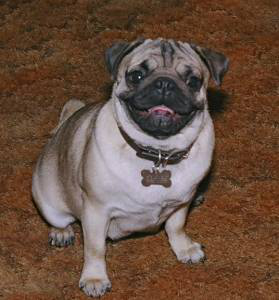

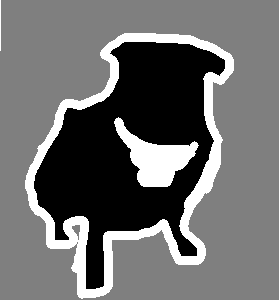

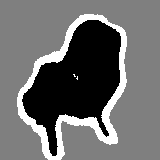

In [10]:
import numpy as np

x, y = val_gen[0]

params, state, opt_state = train_state
val_preds, _ = forward.apply(params, state, None, x, is_training=False)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    #PIL.Image.fromarray currently not working with jax.numpy
    img = ImageOps.autocontrast(Image.fromarray(np.uint8(mask)))
    return img 

# Display results for validation image #10
i = 10

# Display input image
display(Image.open(val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(Image.open(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
img = display_mask(i)
display(img)  # Note that the model only sees inputs at 150x150.